In [27]:
import openai
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
# Add a constant to the model (intercept)
from sklearn.metrics import r2_score
import time
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from source.models import *
from source.preprocessing import *
from source.variables import *
from source.helpers import *

from dotenv import load_dotenv
import os

load_dotenv()  # Load environment variables from .env file

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

In [64]:
# import system_message.txt as a string
with open('prompts/system_qna_rating.txt', 'r') as file:
    system_message = file.read()

print(system_message)

Context:
You are an advanced AI language model trained to analyze financial documents. Your task is to analyze the last earnings call transcripts before default of companies and extract specific features related to Analyst Questions and Management Responses. These features will be used to predict the recovery rate of bonds (the 30-day average bond price after default) issued by these companies.

Objective:
Given the provided earnings call transcript, perform the following tasks:

Separate Analyst Questions and Management Responses:
Identify and separate the sections of the transcript that contain analyst questions and management responses during the Q&A session.
Extract Features Related to Analyst Questions:
[Score1] Severity of Analyst Concerns (0.00 - 1.00):
Identify the main topics and concerns raised by analysts.
Assign a score based on the relevance and seriousness of these concerns regarding the company's financial health and recovery prospects.
A higher score indicates that anal

In [65]:
transcripts = pd.read_csv('transcripts/credit_df.csv', delimiter='|')
aggregated = pd.read_csv('transcripts/aggregated_credit_df.csv', delimiter='|')

aggregated['severity'] = 0.0
aggregated['responsiveness'] = 0.0
aggregated['evasiveness'] = 0.0
aggregated['allignment'] = 0.0

aggregated.head()

,call_ID,aggregated_RR,presentation,QnA,severity,responsiveness,evasiveness,allignment
0,0,29.023972,Presentation\nOperator\nGood morning Ladies an...,Question and Answer\nOperator\n[Operator Instr...,0.0,0.0,0.0,0.0
1,1,8.869420,"Presentation\nOperator\nLadies and gentlemen, ...",Question and Answer\nOperator\n(Operator Instr...,0.0,0.0,0.0,0.0
2,2,33.210455,Presentation\nOperator\nGreetings ladies and g...,Question and Answer\nOperator\nThank you. Ladi...,0.0,0.0,0.0,0.0
3,3,11.875000,"Presentation\nOperator\nThank you, all parties...",Question and Answer\nOperator\n[Operator Instr...,0.0,0.0,0.0,0.0
4,4,18.340000,Presentation\nOperator\nThank you for joining ...,Question and Answer\nOperator\n(Operator Instr...,0.0,0.0,0.0,0.0


In [66]:
client = openai.OpenAI(api_key=OPENAI_API_KEY)

In [67]:
for idx, row in aggregated.iterrows():
    try:
        completion = client.chat.completions.create(
            model="gpt-4o-mini",
            temperature=0,
            messages=[
                {"role": "system", "content": system_message},
                {"role": "user", "content": row['QnA']}
            ]
        )
        # Instantly add the output as a new column entry for the corresponding row
        response = completion.choices[0].message.content

        # Parse response columns and populate the DataFrame
        aggregated.at[idx, 'severity'] = float(response.split('; ')[0]) 
        aggregated.at[idx, 'responsiveness'] = float(response.split('; ')[1])
        aggregated.at[idx, 'evasiveness'] = float(response.split('; ')[2])
        aggregated.at[idx, 'allignment'] = float(response.split('; ')[3])
        
        print(f"Completed for row {idx}")
        print(completion.choices[0].message.content)

    except openai.error.OpenAIError as e:
        print(f"An exception occurred: {e}")
        print("Waiting for 1 minute before retrying...")
        time.sleep(60)


Completed for row 0
0.75; 0.80; 0.20; 0.70
Completed for row 1
0.75; 0.70; 0.60; 0.80
Completed for row 2
0.75; 0.60; 0.40; 0.70
Completed for row 3
0.85; 0.70; 0.60; 0.75
Completed for row 4
0.75; 0.80; 0.20; 0.70
Completed for row 5
0.75; 0.60; 0.80; 0.70
Completed for row 6
0.75; 0.70; 0.60; 0.80
Completed for row 7
0.75; 0.60; 0.70; 0.50
Completed for row 8
0.85; 0.70; 0.60; 0.75
Completed for row 9
0.75; 0.80; 0.20; 0.70
Completed for row 10
0.75; 0.80; 0.20; 0.70
Completed for row 11
0.75; 0.70; 0.40; 0.60
Completed for row 12
0.75; 0.80; 0.20; 0.70
Completed for row 13
0.75; 0.80; 0.30; 0.70
Completed for row 14
0.75; 0.80; 0.20; 0.70
Completed for row 15
0.75; 0.80; 0.60; 0.70
Completed for row 16
0.75; 0.85; 0.20; 0.70
Completed for row 17
0.75; 0.80; 0.20; 0.70
Completed for row 18
0.75; 0.60; 0.40; 0.70
Completed for row 19
0.85; 0.70; 0.60; 0.75
Completed for row 20
0.75; 0.80; 0.60; 0.70
Completed for row 21
0.75; 0.80; 0.60; 0.70
Completed for row 22
0.75; 0.80; 0.30; 0.7

In [68]:
aggregated.head()

,call_ID,aggregated_RR,presentation,QnA,severity,responsiveness,evasiveness,allignment
0,0,29.023972,Presentation\nOperator\nGood morning Ladies an...,Question and Answer\nOperator\n[Operator Instr...,0.75,0.8,0.2,0.70
1,1,8.869420,"Presentation\nOperator\nLadies and gentlemen, ...",Question and Answer\nOperator\n(Operator Instr...,0.75,0.7,0.6,0.80
2,2,33.210455,Presentation\nOperator\nGreetings ladies and g...,Question and Answer\nOperator\nThank you. Ladi...,0.75,0.6,0.4,0.70
3,3,11.875000,"Presentation\nOperator\nThank you, all parties...",Question and Answer\nOperator\n[Operator Instr...,0.85,0.7,0.6,0.75
4,4,18.340000,Presentation\nOperator\nThank you for joining ...,Question and Answer\nOperator\n(Operator Instr...,0.75,0.8,0.2,0.70


In [109]:
# merge output_df with transcripts on 'transcript_number' and index
transcripts = pd.merge(transcripts,
                          aggregated[['call_ID', 'severity', 'responsiveness', 'evasiveness', 'allignment']],
                          on='call_ID',
                          how='left')

checkpoint = transcripts.copy()

# replace #DIV/0! & Nan with 0
# Replace '#DIV/0!' with NaN
checkpoint.replace('#DIV/0!', np.nan, inplace=True)
checkpoint = checkpoint.fillna(0)

# make sure all values are numeric except for the Date column
checkpoint = checkpoint.apply(pd.to_numeric, errors='ignore')

In [70]:
# save checkpoint as csv
checkpoint.to_csv('transcripts/LLM_QnA_analysis.csv', index=False)
#checkpoint = pd.read_csv('transcripts/LLM_outputs_QnA.csv')

In [111]:
# List of selected supporting features
supporting_features_1 = [
    'CBOE DJIA Volatility Index',
    'NASDAQ 100 Index return',
    'Manufacturers inventories to sales ratio',
    '30 year conventional mortgage rate',
    'Communication Services', 
    'Consumer Discretionary', 
    'Senior secured',  
    'Time to maturity',  
    'Equity value',
    'CDS availability',
    'ActIndustryDistress1',
    'ActIndustryDistress2',
    'Offering amount',
    'Volume',
    'Industrials','Consumer Staples','Financials','Energy','Health Care','Utilities','Information Technology','Real Estate'
]

supporting_features_2 = [
    'Default barrier',
    'LTDIssuance2',
    'Intangibility',
    'Receivables1',
]

llm_labels = ['severity', 'responsiveness', 'evasiveness', 'allignment']

In [112]:
'''COMPANY LEVEL'''
# Select the supporting features, nlp_lables, and RR from final_df
final_df = checkpoint[['aggregated_RR']
                    #+ supporting_features_1
                    #+ supporting_features_2
                    + llm_labels ]

# reset index
final_df = final_df.reset_index(drop=True)
# drop duplicates
final_df = final_df.drop_duplicates()

y_train, y_test = final_df['aggregated_RR'], final_df['aggregated_RR']
X_train, X_test = final_df.drop(columns=['aggregated_RR']), final_df.drop(columns=['aggregated_RR'])

                            OLS Regression Results                            
Dep. Variable:          aggregated_RR   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.5640
Date:                Tue, 08 Oct 2024   Prob (F-statistic):              0.689
Time:                        14:09:18   Log-Likelihood:                -932.77
No. Observations:                 196   AIC:                             1876.
Df Residuals:                     191   BIC:                             1892.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             37.0432     15.396      2.

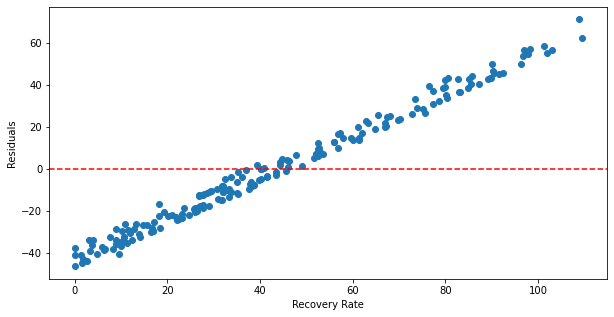

In [113]:
# LLM features

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# other metric
# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()

In [114]:
# Compute variance inflation factor 
vif = pd.DataFrame()
vif["Features"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)

# Display the VIF
print(vif)

         Features        VIF
0           const  56.842451
1        severity   4.312222
4      allignment   4.224029
2  responsiveness   2.693522
3     evasiveness   1.695230


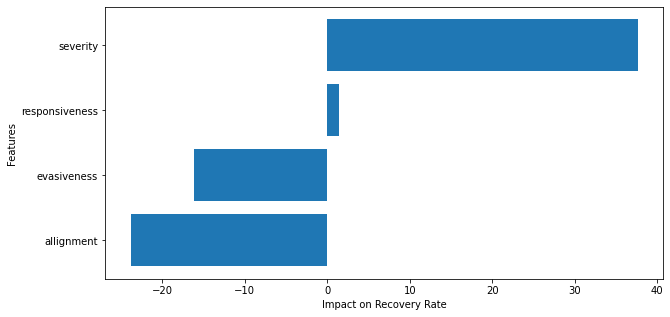

In [115]:
# build a graph to show the importance of each feature
importances = model.params[1:]
importances = importances.sort_values()

plt.figure(figsize=(10, 5))
plt.barh(importances.index, importances.values)
plt.xlabel('Impact on Recovery Rate')
plt.ylabel('Features')
plt.show()

In [116]:
'''BOND LEVEL'''
# Select the supporting features, nlp_lables, and RR from final_df
final_df = checkpoint[['Date'] 
                    #+ supporting_features_1
                    #+ supporting_features_2
                    + llm_labels 
                    + ['RR']]

# In-Sample-Regression
y_train, y_test = final_df['RR'], final_df['RR']
X_train, X_test = final_df.drop(columns=['RR', 'Date']), final_df.drop(columns=['RR', 'Date'])

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     26.93
Date:                Tue, 08 Oct 2024   Prob (F-statistic):           2.58e-21
Time:                        14:09:40   Log-Likelihood:                -4970.2
No. Observations:                1075   AIC:                             9950.
Df Residuals:                    1070   BIC:                             9975.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             53.1321     11.542      4.

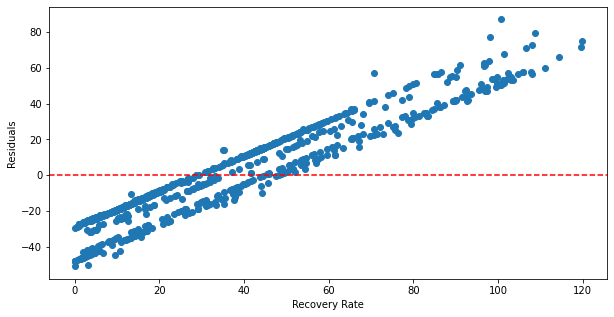

In [117]:
# LLM features

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# other metric
# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()

In [118]:
# Compute variance inflation factor 
vif = pd.DataFrame()
vif["Features"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)

# Display the VIF
print(vif)

         Features         VIF
0           const  234.711781
1        severity    5.181714
4      allignment    4.741721
3     evasiveness    2.744798
2  responsiveness    1.761417


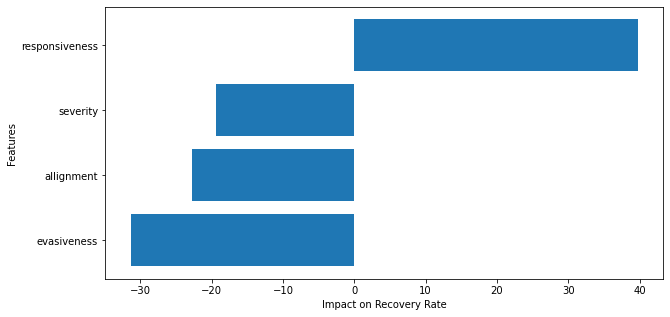

In [119]:
# build a graph to show the importance of each feature
importances = model.params[1:]
importances = importances.sort_values()

plt.figure(figsize=(10, 5))
plt.barh(importances.index, importances.values)
plt.xlabel('Impact on Recovery Rate')
plt.ylabel('Features')
plt.show()